# Use CellProfiler Features Extracted to Construct a knn Network

## Import data and split into training/test set

In [31]:
import pandas as pd
import numpy as np

raw_data = pd.read_csv(r"..\data\processed\cellprofiler_data.csv")
data = raw_data.drop(["Phenotype", "ImageNumber"], axis=1)
labels = raw_data["Phenotype"]
data = data.to_numpy()
labels = labels.to_numpy()
phenotype = {"alveolar": 0,
             "marrow": 1,
             "monocyte": 2}
labels = [phenotype[label] for label in labels]

from random import shuffle
train_index = [[] for _ in range(len(phenotype))] 
test_index = [[] for _ in range(len(phenotype))]

[train_index[labels[i]].append(i) for i in range(len(labels))]

for i in range(len(train_index)):
    tmp = train_index[i]
    shuffle(tmp)

    test_len = int(len(tmp)/5)
    test_index[i].extend(tmp[:test_len])
    train_index[i] = tmp[test_len:]

tmp = []
[tmp.extend(inds) for inds in train_index]
train_index = tmp

train_samples = np.stack([data[ind] for ind in train_index])
train_labels = np.stack([labels[ind] for ind in train_index])

tmp = []
[tmp.extend(inds) for inds in test_index]
test_index = tmp

test_samples = np.stack([data[ind] for ind in test_index])
test_labels = np.stack([labels[ind] for ind in test_index])

## Use raw KNeighbors on chosen data

In [32]:
from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=len(phenotype))
knn.fit(train_samples, train_labels)

out = list(knn.predict(test_samples))
correct = 0
total = len(out)
for pred, label in zip(out, test_labels):
    correct += int(pred == label)

accuracy = correct / total

print(f"accuracy of knn: {accuracy:>0.2%}")

num_classes = max(out) + 1

confusion_matrix = np.zeros((num_classes, num_classes))

for t, p in zip(out, test_labels):
    confusion_matrix[int(t), int(p)] += 1

matrix = np.array(confusion_matrix)
matrix = np.array([i/sum(i) for i in matrix])

test_accuracy = 0
for i in range(num_classes):
    test_accuracy += confusion_matrix[i,i]
test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

print(matrix)
print("alveolar", "marrow", "monocyte")

accuracy of knn: 72.41%
[[0.74949495 0.03232323 0.21818182]
 [0.01674641 0.79425837 0.18899522]
 [0.24715909 0.14772727 0.60511364]]
alveolar marrow monocyte


## PCA of data

Explained variation per principal component: [6.16998693e-01 3.10033447e-01 1.94496296e-02 1.15070607e-02
 9.99599798e-03 7.66838910e-03 4.93247053e-03 4.06366655e-03
 3.30264534e-03 2.50279074e-03 1.38891028e-03 1.30001094e-03
 1.00410714e-03 8.91301307e-04 7.45289654e-04 5.50871834e-04
 4.59042640e-04 3.91680463e-04 3.49872564e-04 2.76962594e-04
 2.28202785e-04 2.08129612e-04 2.00307064e-04 1.85405619e-04
 1.65076330e-04]


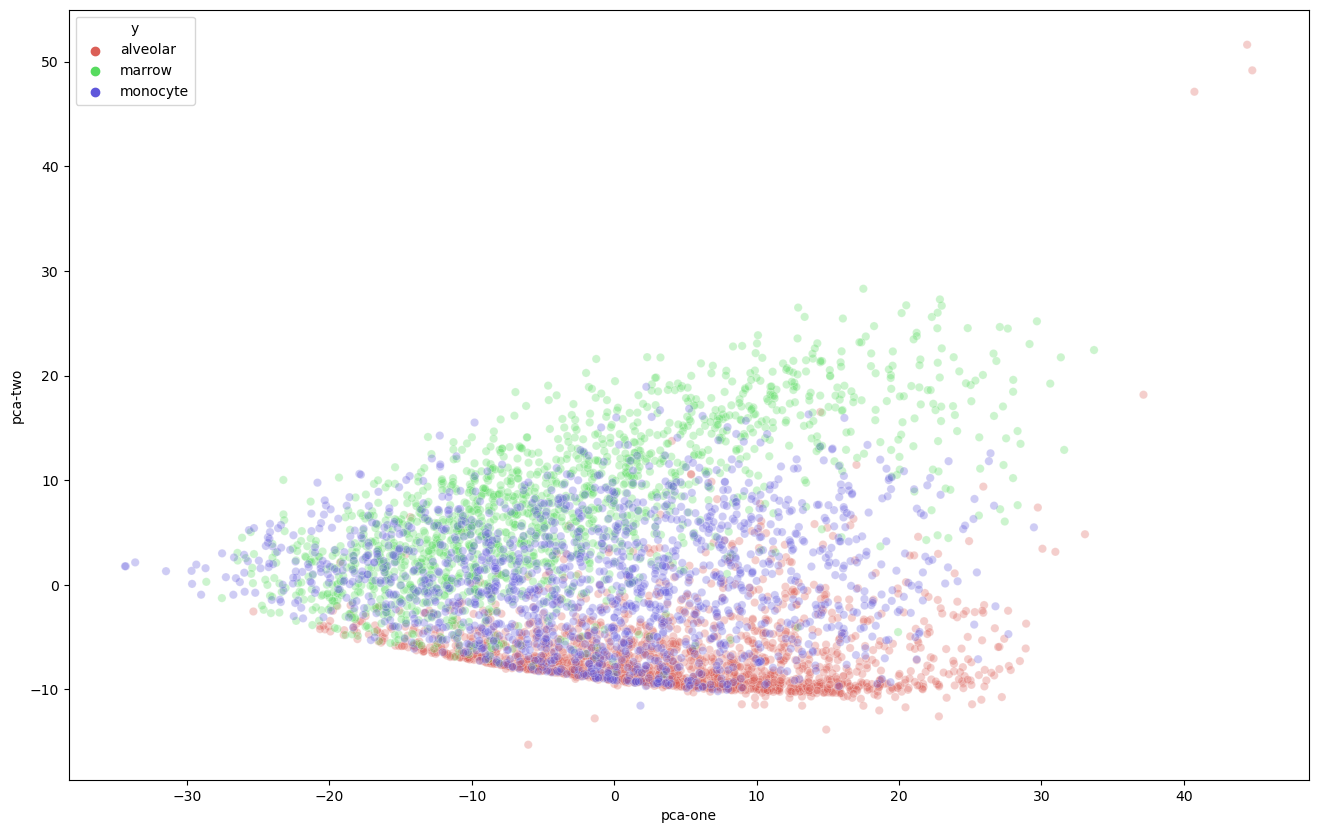

In [39]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
sc.fit(train_samples)
std_data = sc.transform(train_samples)

num_comp = 25

pca = PCA(n_components=num_comp)
pca.fit(std_data)
pca_result = pca.transform(std_data)

graph_data = pd.DataFrame()
graph_data['pca-one'] = pca_result[:,0]
graph_data['pca-two'] = pca_result[:,1] 
graph_data['pca-three'] = pca_result[:,2]  

reverse_pheno = {v: k for k, v in phenotype.items()}

graph_data['y'] = [reverse_pheno[label] for label in train_labels]


print('Explained variation per principal component: {}'.format(pca.explained_variance_ratio_))

import seaborn as sns
from matplotlib import pyplot as plt
plt.figure(figsize=(10,10))
sns.scatterplot(
    x="pca-one", y="pca-two",
    hue="y",
    palette=sns.color_palette("hls", 3),
    data=graph_data,
    legend="full",
    alpha=0.3
)
plt.show()

## Using PCA modified dataset with KNN

In [41]:
knn_pca = KNeighborsClassifier(n_neighbors=len(phenotype))
knn.fit(pca_result, train_labels)

std_test_data = sc.transform(test_samples)
pca_test_data = pca.transform(std_test_data)

out = list(knn.predict(pca_test_data))
correct = 0
total = len(out)
for pred, label in zip(out, test_labels):
    correct += int(pred == label)

accuracy = correct / total

print(f"accuracy of knn: {accuracy:>0.2%}")

accuracy of knn: 72.89%


In [42]:
confusion_matrix = np.zeros((num_classes, num_classes))

for t, p in zip(out, test_labels):
    confusion_matrix[int(t), int(p)] += 1

matrix = np.array(confusion_matrix)
matrix = np.array([i/sum(i) for i in matrix])

test_accuracy = 0
for i in range(num_classes):
    test_accuracy += confusion_matrix[i,i]
test_accuracy = test_accuracy / sum(confusion_matrix.flatten())

print(matrix)

[[0.74148297 0.03206413 0.22645291]
 [0.01496259 0.82294264 0.16209476]
 [0.24383562 0.14794521 0.60821918]]


## T-SNE of Data

In [58]:
from sklearn.manifold import TSNE

TSNE = TSNE(n_components=2, perplexity=50, n_iter=5000, learning_rate=200)

tsne_results = TSNE.fit_transform(pca_result)



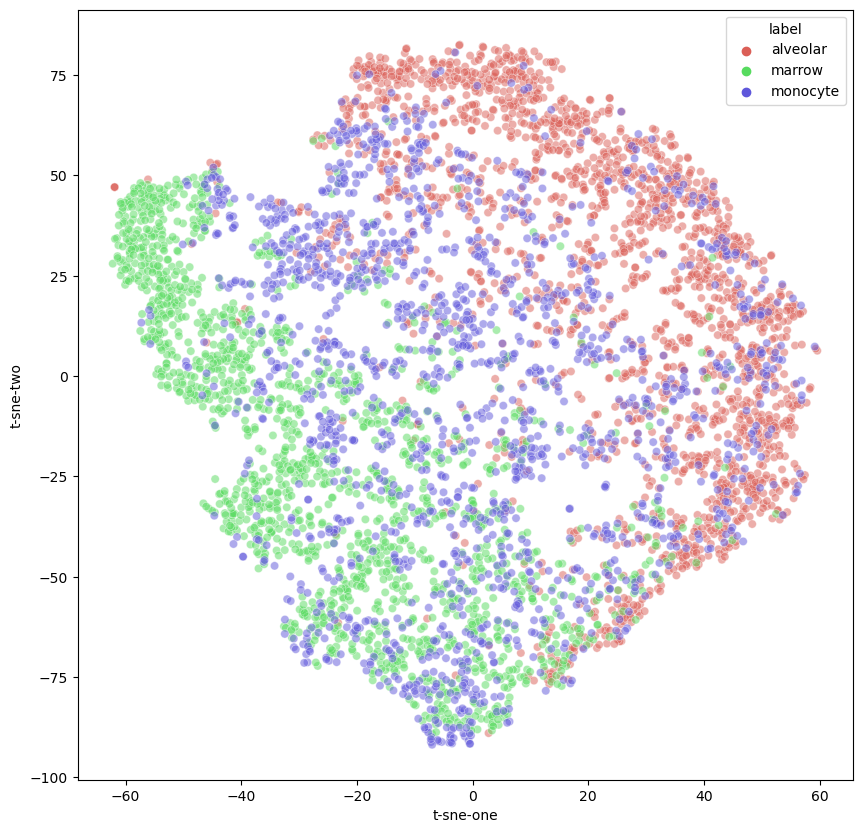

In [67]:
# visualize
df_tsne = pd.DataFrame(tsne_results, columns=['t-sne-one', 't-sne-two'])
df_tsne['label'] = [reverse_pheno[label] for label in train_labels]

plt.figure(figsize=(10,10))
sns.scatterplot(
    x="t-sne-one", y="t-sne-two",
    hue="label",
    palette=sns.color_palette("hls", 3),
    data=df_tsne,
    legend="full",
    alpha=0.5
)
plt.show()